# 1.1 第三种补全方法
## 1.1.1 点云距离的方法寻找gb通道的补全方法所需要的底层子程序

In [1]:
#寻找每个通道需要平移多少的子程序,return dist_min, mov_num[0][0],B_new


import numpy as np
import math
import copy

# 不以科学计数显示
np.set_printoptions(suppress=True)

def GetDistOfPoints2D(set1, set2):
    '''
    求出两个点的距离
    '''
    return sum(abs(set1[1]-set2[1]))
    #return sum(abs(set1[1]-set2[1])*set1[0])
    #return sum((set1[1]-set2[1]))
def GetDistOf2DPointsSet(set1, set2):
    '''
    求两个点集之间的平均点距
    '''
    return GetDistOfPoints2D(set1, set2)/set1.shape[1]
def ICP_2D(targetPoints, sourcePoints):
    '''
    二维 ICP 配准算法
    '''
    A = targetPoints  # A是目标点云（r值）
    B = sourcePoints  # B是源点云（g或b值）
    dist_lst=[]
    B_new=np.array(np.zeros_like(B))
    # 初始化迭代参数
    dist_now = 0  # A,B两点集之间初始化距离
    dist_improve = 0  # A,B两点集之间初始化距离提升
    dist_before = GetDistOf2DPointsSet(A, B)  # A,B两点集之间距离
    B_new=B
    # 每个点计算距离，循环右移
    for i in range(B.shape[1]):
        B_new[0,:]=B[0,:]              
        B_new[1,0]=B[1,-1]
        B_new[1,1:]=B[1,:-1]        
        B = B_new
        dist_now = GetDistOf2DPointsSet(A, B)
        dist_lst.append(dist_now)        
        #print(dist_lst)
        # 更新迭代
    dist_min = np.min(dist_lst)  # 更新两个点云之间的距离
    mov_num =  np.where(dist_lst==dist_min)[0][0]#距离最小的数组位置   
    dist_improve = dist_before - dist_min  # 计算这一次迭代两个点云之间缩短的距离
    print(mov_num, dist_min, dist_improve)
    # 打印迭代次数、损失距离、损失提升
    print("移动：{}个，距离：{:.2f}，缩短：{:.2f}".format(mov_num, dist_min, dist_improve))  
    
    if mov_num!=0:
        B_new[0,:]=sourcePoints[0,:]
        B_new[1,mov_num:]=sourcePoints[1,:-mov_num]
        B_new[1,0:mov_num]=sourcePoints[1,-mov_num:]
        #np.repeat(sourcePoints[1,0],mov_num[0][0])#修改
    
    return dist_min, mov_num,B_new,dist_lst

# 2 gb通道补齐的第三种方法

# 2.1 new_imgc3_255_ours(im_path)：批量补全图片并保存
## 批量补全图片并保存
## 升级版，去出红黄紫，用255

In [2]:
#批量补全图片并保存
# 升级版，去出红黄紫，用255

import numpy as np
import PIL
from PIL import Image
import os
import glob
from  matplotlib import pyplot as plt
%matplotlib inline
import cv2
import numpy as np
#Num=0

#lst = glob.glob('./jietu/*.*')
#lst = glob.glob('./our_sand/*.png')
#lst = glob.glob('./new_sand_pic_4/*.jpg')
#print(len(lst))
#im_path='./jietu/*.*'
def new_imgc3_255_ours(im_path):
    lst = glob.glob(im_path)
    print('im_path')
    print(im_path)
    for i in range(len(lst)):
        # 1 获取某张图片每个通道的数据：hisr，hisg,hisb
        img = cv2.imread(lst[i], 1)
        print(lst[i],img.shape)

        chans = cv2.split(img)
        colors = ('b', 'g', 'r')

        plt.figure('颜色直方图')
        plt.title(lst[i])
        plt.xlabel("Bins")
        plt.ylabel("# of Pixels")
        hist_all=[]
        for (chan, color) in zip(chans, colors):
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            plt.plot(hist, color = color)
            plt.xlim([0, 256])
            print(type(hist),hist.shape)
            hist_all.append(hist)


        plt.show() 

        histb=np.squeeze(hist_all[0],1)
        histg=np.squeeze(hist_all[1],1)
        histr=np.squeeze(hist_all[2],1)
        lstn = list(range(256))
        hisr = np.array([lstn,histr])
        hisg = np.array([lstn,histg])
        hisb = np.array([lstn,histb])

        # 2 计算gb通道补全的数值
        dist_min, mov_num_b,B_new,_=ICP_2D(hisr, hisb)
        dist_min, mov_num_g,g_new,_=ICP_2D(hisr, hisg)
        plt.title(lst[i]+'c3_255')
        plt.plot(B_new[0],g_new[1], color = 'g')
        plt.plot(hisr[0],hisr[1], color = 'r')
        plt.plot(B_new[0],B_new[1], color = 'b')
        plt.show()
        # 3 补全gb通道
        print(mov_num_g,mov_num_b)
        im = np.array(Image.open(lst[i]))
        r = im[:,:,0]
        g = np.uint16(im[:,:,1]) +mov_num_g
        b = np.uint16(im[:,:,2]) +mov_num_b

        ##gb通道中大于255的置为255
        g_new=[]
        for i1 in g:
            for j1 in i1:
                #print(j)    
                if j1>255:
                    j1=255
                g_new.append(j1)
        g_np=np.array(g_new).reshape(g.shape[0],g.shape[1])
        ##gb通道中大于255的置为255
        b_new=[]
        for i1 in b:
            for j1 in i1:
                #print(j)    
                if j1>255:
                    j1=255
                b_new.append(j1)
        b_np=np.array(b_new).reshape(b.shape[0],b.shape[1])
        ##gb通道中大于255的置为255##end

        im_n_new = np.dstack([r,g_np,b_np])
        im_c = Image.fromarray(im_n_new.astype('uint8')).convert('RGB')
        # 4 保存补全结果
        base_dir = ('/').join(lst[i].split('/')[:-1])
        print('base_dir')
        print(base_dir)
        new_dir = os.path.join(base_dir,'output3_255')
        print('new_dir')
        print(new_dir)
        img_name = lst[i].split('/')[-1].split('.')[0]+'_c3_255.png'
        new_path = os.path.join(new_dir,img_name)
        if os.path.isdir(new_dir):  ##不用加引号，如果是多级目录，只判断最后一级目录是否存在
            pass
        else:
            print (new_dir+'dir not exists')
            os.mkdir(new_dir)     
        im_c.save(new_path)
        print('mov_num_b')
        print(mov_num_b)
        print('mov_num_g')
        print(mov_num_g)        

# 2.2 new_imgc3_r_ours(im_path)：批量补全图片并保存
## 批量补全图片并保存
## 升级版，去出红黄紫，用r通道¶


In [3]:
#批量补全图片并保存
# 升级版，取出红黄紫,用r通道

import numpy as np
import PIL
from PIL import Image
import os
import glob
from  matplotlib import pyplot as plt
%matplotlib inline
import cv2
import numpy as np
#Num=0
im_path = './jietu/*.*'
def new_imgc3_r_ours(im_path):
    lst = glob.glob(im_path)
    #lst = glob.glob('./our_sand/*.png')
    #lst = glob.glob('./new_sand_pic_4/*.jpg')
    print(len(lst))

    for i in range(len(lst)):
        # 1 获取某张图片每个通道的数据：hisr，hisg,hisb
        img = cv2.imread(lst[i], 1)
        print(lst[i],img.shape)

        chans = cv2.split(img)
        colors = ('b', 'g', 'r')

        plt.figure('颜色直方图')
        plt.title(lst[i])
        plt.xlabel("Bins")
        plt.ylabel("# of Pixels")
        hist_all=[]
        for (chan, color) in zip(chans, colors):
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            plt.plot(hist, color = color)
            plt.xlim([0, 256])
            print(type(hist),hist.shape)
            hist_all.append(hist)


        plt.show() 

        histb=np.squeeze(hist_all[0],1)
        histg=np.squeeze(hist_all[1],1)
        histr=np.squeeze(hist_all[2],1)
        lstn = list(range(256))
        hisr = np.array([lstn,histr])
        hisg = np.array([lstn,histg])
        hisb = np.array([lstn,histb])

        # 2 计算gb通道补全的数值
        dist_min, mov_num_b,B_new,_=ICP_2D(hisr, hisb)
        dist_min, mov_num_g,g_new,_=ICP_2D(hisr, hisg)
        plt.title(lst[i]+'c3_r')
        plt.plot(g_new[0],g_new[1], color = 'g')
        plt.plot(hisr[0],hisr[1], color = 'r')
        plt.plot(B_new[0],B_new[1], color = 'b')
        plt.show()
        # 3 补全gb通道
        print(mov_num_g,mov_num_b)
        #疑似顺序弄反了，后续逆着用，
        im = np.array(Image.open(lst[i]))
        r = im[:,:,0]
        #g = im[:,:,1] +mov_num_b#效果更差
        #b = im[:,:,2] +mov_num_g#效果更差
        g = np.uint16(im[:,:,1]) +mov_num_g
        b = np.uint16(im[:,:,2]) +mov_num_b
        
        
        ##gb通道中大于255的置为r
        g_new=[]
        for m,i1 in (enumerate(g)):
            for n,j1 in (enumerate(i1)): 
                #print(j)    
                if g[m,n]>=255:#if j1>=255:
                    j1=r[m,n]
                g_new.append(j1)
        g_np=np.array(g_new).reshape(g.shape[0],g.shape[1])
        ##gb通道中大于255的置为r
        b_new=[]
        for m,i1 in (enumerate(b)):
            for n,j1 in (enumerate(i1)):   
                if b[m,n]>=255:#if j1>=255:
                    j1=r[m,n]
                b_new.append(j1)
        b_np=np.array(b_new).reshape(b.shape[0],b.shape[1])
        ##gb通道中大于255的置为255##end

        im_n_new = np.dstack([r,g_np,b_np])
        im_c = Image.fromarray(im_n_new.astype('uint8')).convert('RGB')
        # 4 保存补全结果
        base_dir = ('/').join(lst[i].split('/')[:-1])
        new_dir = os.path.join(base_dir,'output3_r')
        img_name = lst[i].split('/')[-1].split('.')[0]+'_c3_r.png'
        new_path = os.path.join(new_dir,img_name)
        if os.path.isdir(new_dir):  ##不用加引号，如果是多级目录，只判断最后一级目录是否存在
            pass
        else:
            print (new_dir+'dir not exists')
            os.mkdir(new_dir)     
        im_c.save(new_path)


# 3 使用例子

9
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/1 (74).jpg (648, 900, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


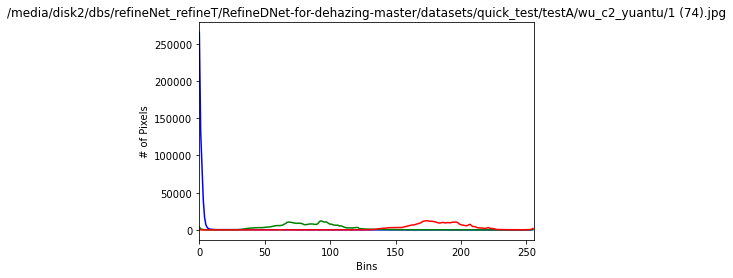

170 2847.98046875 1629.94921875
移动：170个，距离：2847.98，缩短：1629.95
100 454.80859375 3868.76953125
移动：100个，距离：454.81，缩短：3868.77


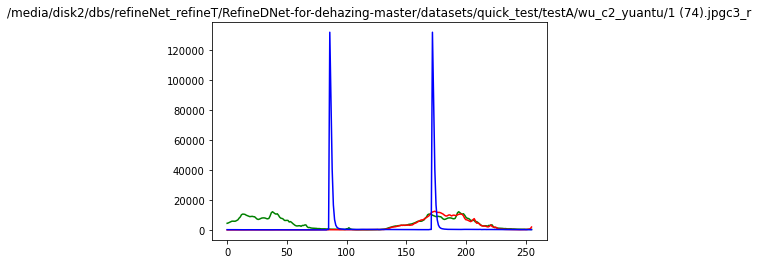

100 170
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_rdir not exists
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/152.jpg (512, 512, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


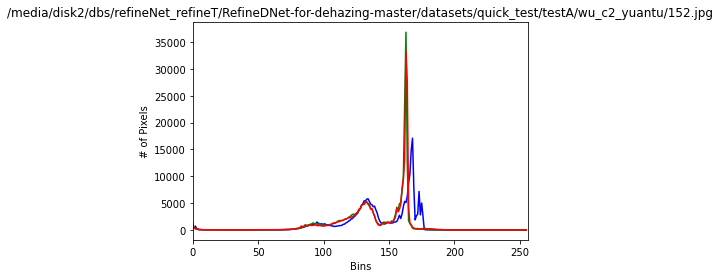

250 398.98046875 337.45703125
移动：250个，距离：398.98，缩短：337.46
254 190.94140625 -2.82421875
移动：254个，距离：190.94，缩短：-2.82


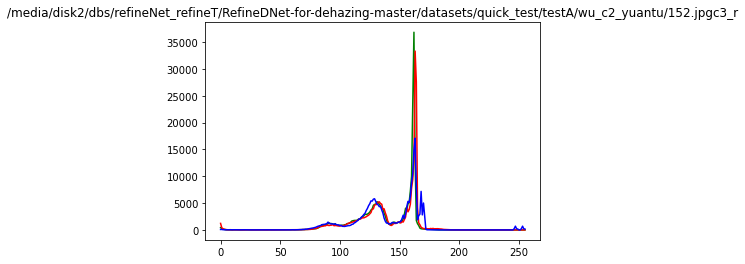

254 250
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/32.png (2611, 1958, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


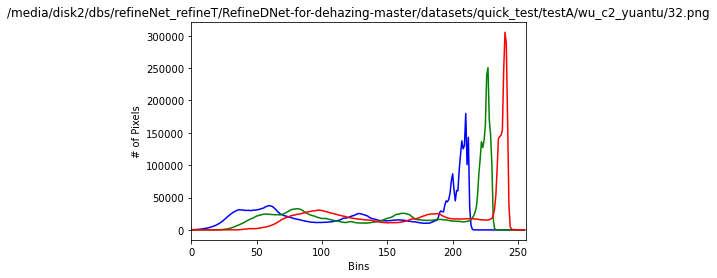

29 9108.46484375 13010.74609375
移动：29个，距离：9108.46，缩短：13010.75
12 4661.4765625 14513.0625
移动：12个，距离：4661.48，缩短：14513.06


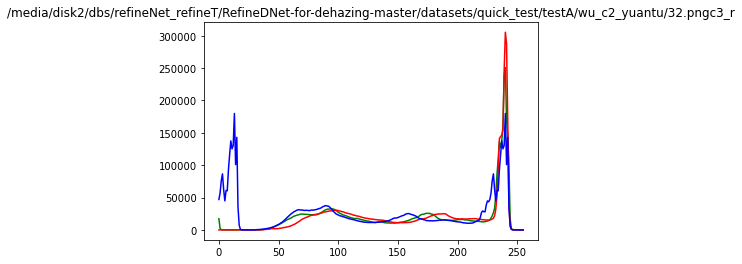

12 29
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/35.png (2611, 1958, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


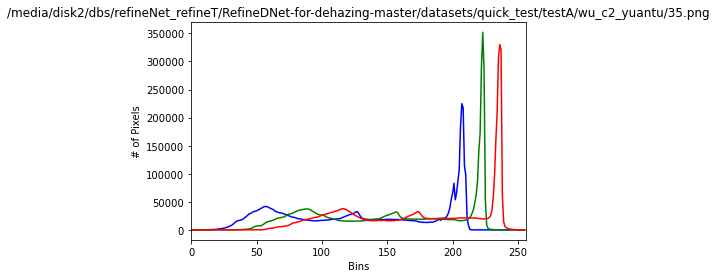

27 9043.87109375 10886.33203125
移动：27个，距离：9043.87，缩短：10886.33
12 4044.20703125 13570.73828125
移动：12个，距离：4044.21，缩短：13570.74


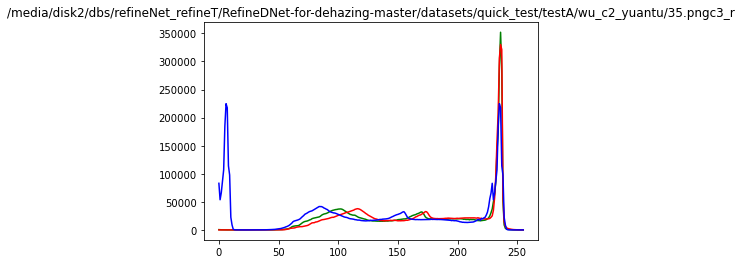

12 27
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/37.png (2611, 1958, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


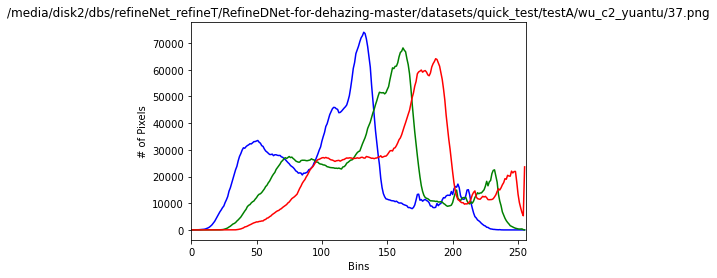

54 4676.65625 14556.2109375
移动：54个，距离：4676.66，缩短：14556.21
24 2702.4921875 9590.5546875
移动：24个，距离：2702.49，缩短：9590.55


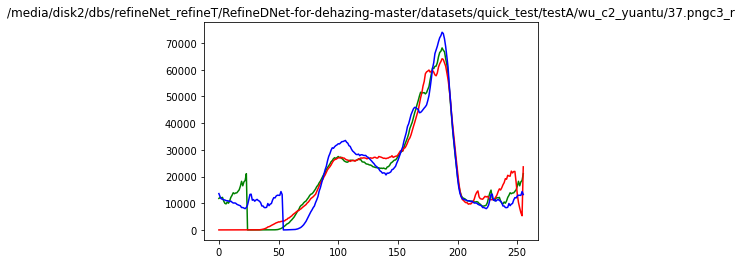

24 54
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/38.png (2611, 1958, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


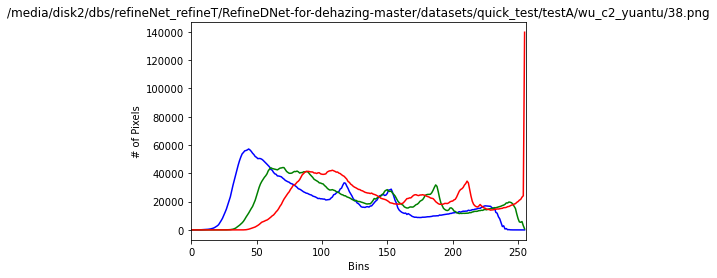

43 7369.921875 7628.1953125
移动：43个，距离：7369.92，缩短：7628.20
22 3711.62109375 4838.47265625
移动：22个，距离：3711.62，缩短：4838.47


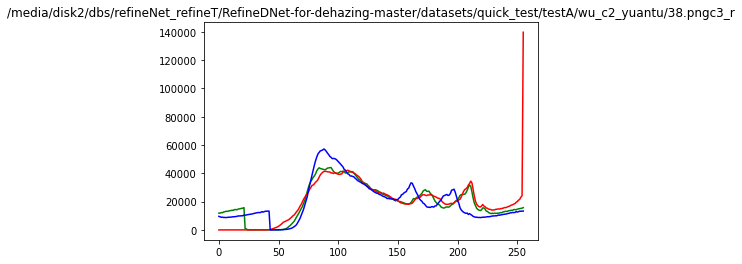

22 43
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/sd185.jpg (332, 512, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


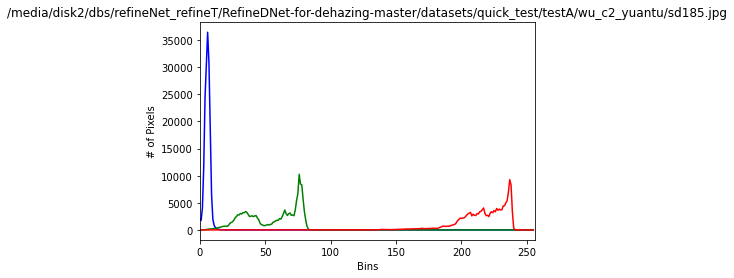

228 930.9296875 397.0703125
移动：228个，距离：930.93，缩短：397.07
159 343.65625 984.34375
移动：159个，距离：343.66，缩短：984.34


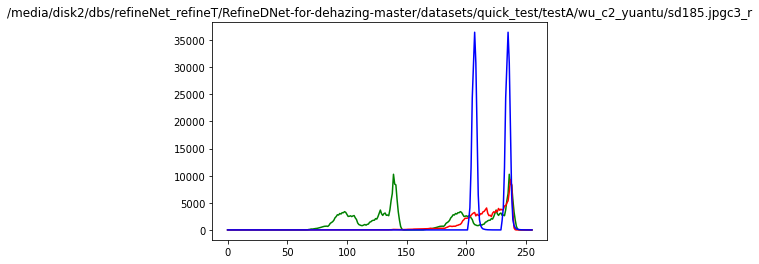

159 228
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/sd2.jpg (511, 766, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


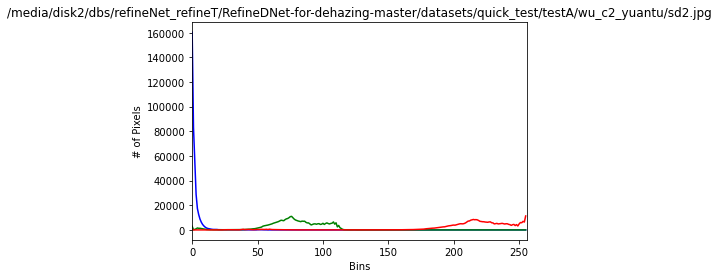

211 1854.09765625 1186.70703125
移动：211个，距离：1854.10，缩短：1186.71
142 428.10546875 2528.55078125
移动：142个，距离：428.11，缩短：2528.55


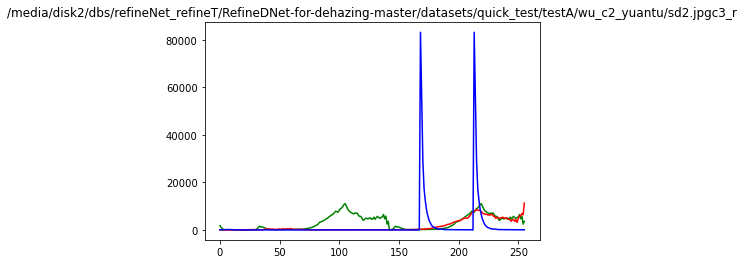

142 211
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/sd43.jpg (1067, 1600, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


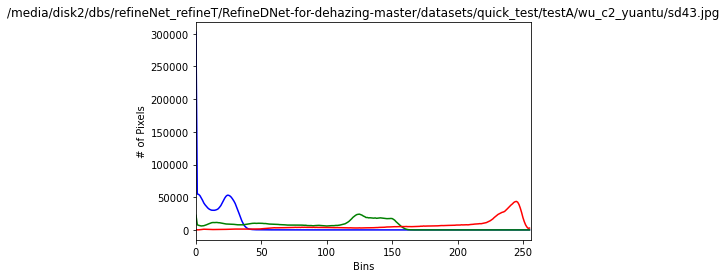

216 5322.01171875 7682.68359375
移动：216个，距离：5322.01，缩短：7682.68
97 4139.828125 5714.6640625
移动：97个，距离：4139.83，缩短：5714.66


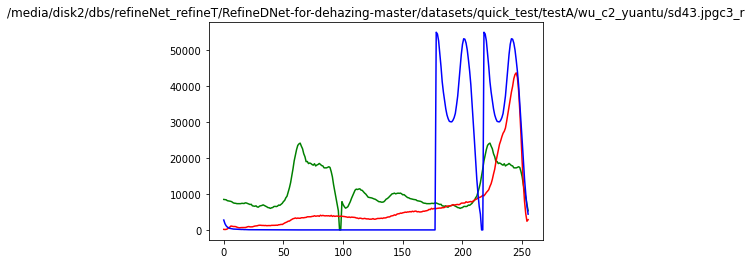

97 216


In [7]:
# 1 执行之前所有子程序后，修改为输入图片所在的路径
#im_path='./TestData_20210817/sand_dust_82/*.jpg'
im_path='/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/*.*g'
# 2 执行操作
new_imgc3_r_ours(im_path)

im_path
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/*.*g
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/1 (74).jpg (648, 900, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


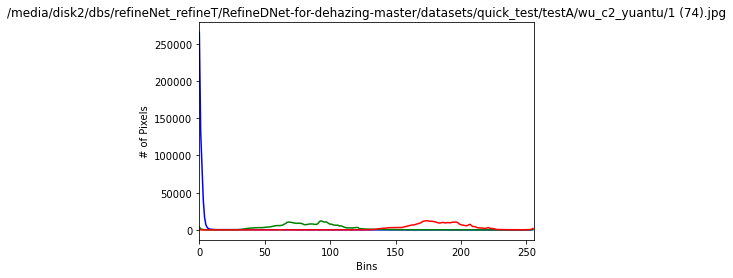

170 2847.98046875 1629.94921875
移动：170个，距离：2847.98，缩短：1629.95
100 454.80859375 3868.76953125
移动：100个，距离：454.81，缩短：3868.77


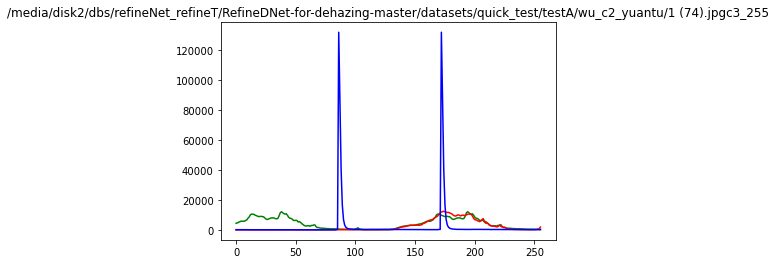

100 170
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
170
mov_num_g
100
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/152.jpg (512, 512, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


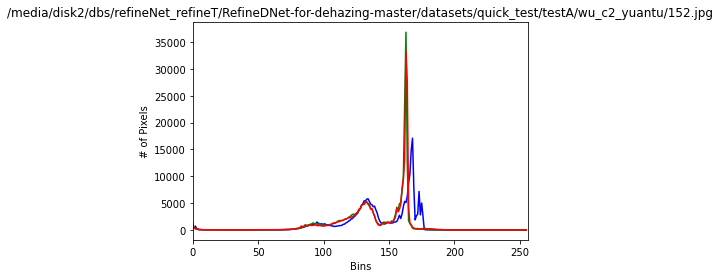

250 398.98046875 337.45703125
移动：250个，距离：398.98，缩短：337.46
254 190.94140625 -2.82421875
移动：254个，距离：190.94，缩短：-2.82


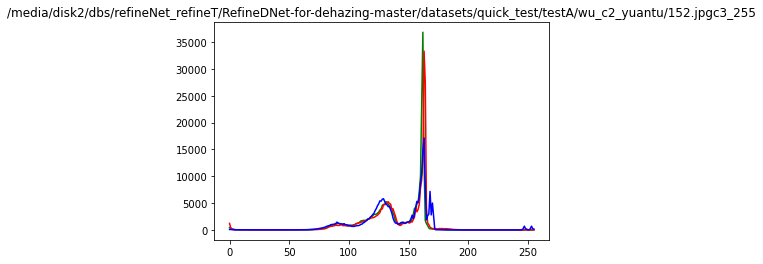

254 250
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
250
mov_num_g
254
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/32.png (2611, 1958, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


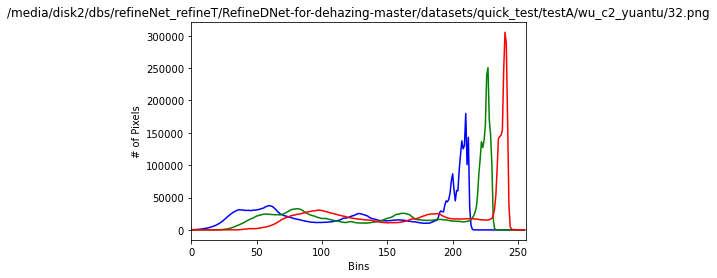

29 9108.46484375 13010.74609375
移动：29个，距离：9108.46，缩短：13010.75
12 4661.4765625 14513.0625
移动：12个，距离：4661.48，缩短：14513.06


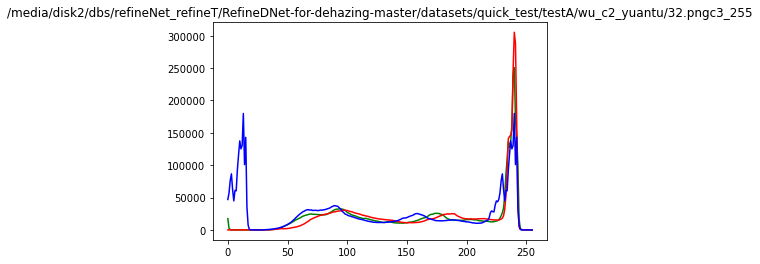

12 29
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
29
mov_num_g
12
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/35.png (2611, 1958, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


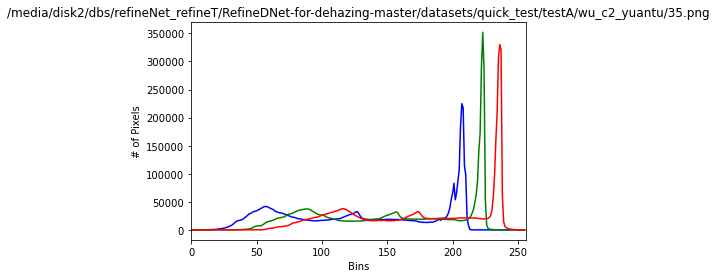

27 9043.87109375 10886.33203125
移动：27个，距离：9043.87，缩短：10886.33
12 4044.20703125 13570.73828125
移动：12个，距离：4044.21，缩短：13570.74


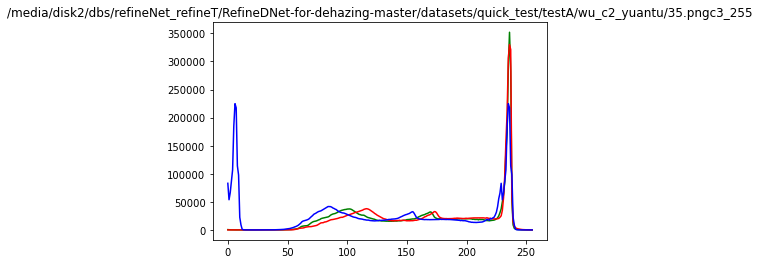

12 27
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
27
mov_num_g
12
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/37.png (2611, 1958, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


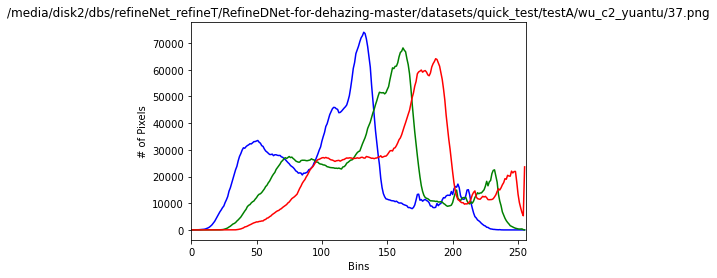

54 4676.65625 14556.2109375
移动：54个，距离：4676.66，缩短：14556.21
24 2702.4921875 9590.5546875
移动：24个，距离：2702.49，缩短：9590.55


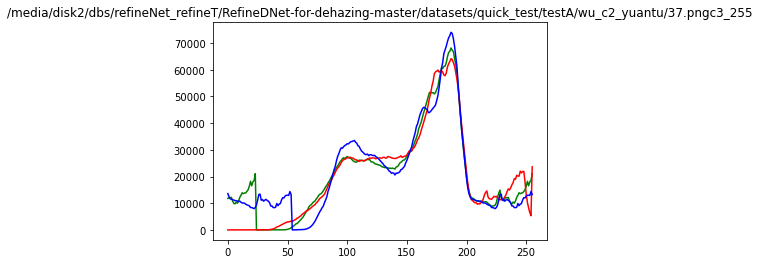

24 54
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
54
mov_num_g
24
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/38.png (2611, 1958, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


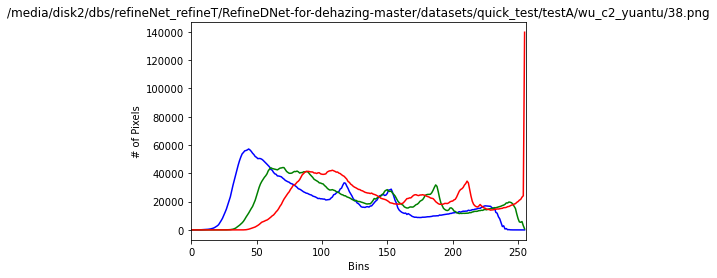

43 7369.921875 7628.1953125
移动：43个，距离：7369.92，缩短：7628.20
22 3711.62109375 4838.47265625
移动：22个，距离：3711.62，缩短：4838.47


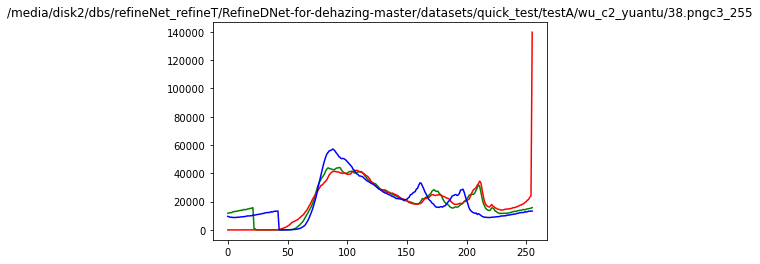

22 43
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
43
mov_num_g
22
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/sd185.jpg (332, 512, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


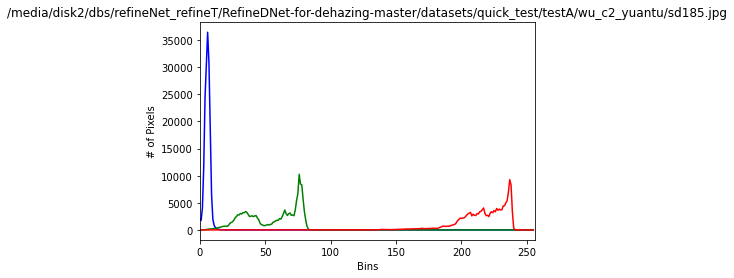

228 930.9296875 397.0703125
移动：228个，距离：930.93，缩短：397.07
159 343.65625 984.34375
移动：159个，距离：343.66，缩短：984.34


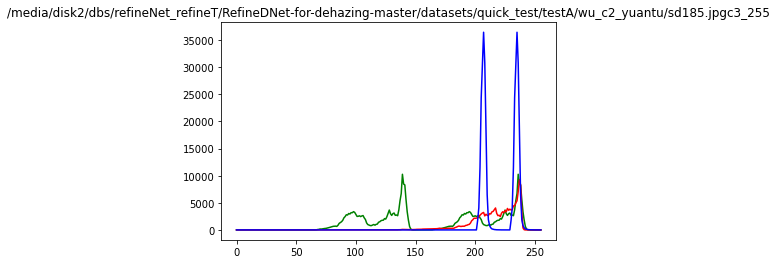

159 228
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
228
mov_num_g
159
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/sd2.jpg (511, 766, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


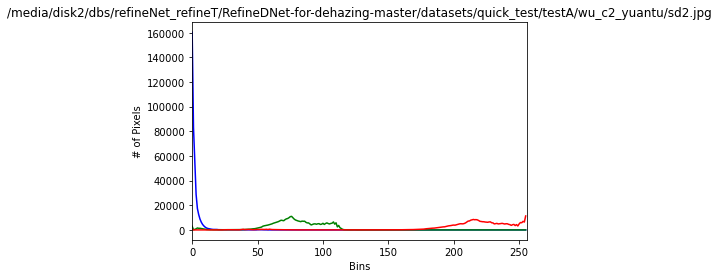

211 1854.09765625 1186.70703125
移动：211个，距离：1854.10，缩短：1186.71
142 428.10546875 2528.55078125
移动：142个，距离：428.11，缩短：2528.55


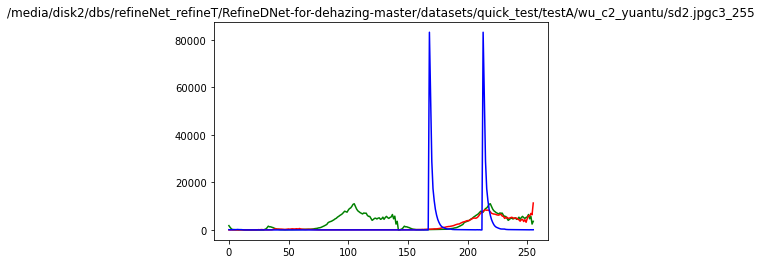

142 211
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
211
mov_num_g
142
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/sd43.jpg (1067, 1600, 3)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)
<class 'numpy.ndarray'> (256, 1)


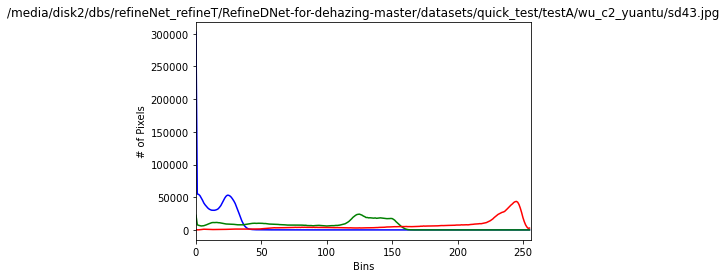

216 5322.01171875 7682.68359375
移动：216个，距离：5322.01，缩短：7682.68
97 4139.828125 5714.6640625
移动：97个，距离：4139.83，缩短：5714.66


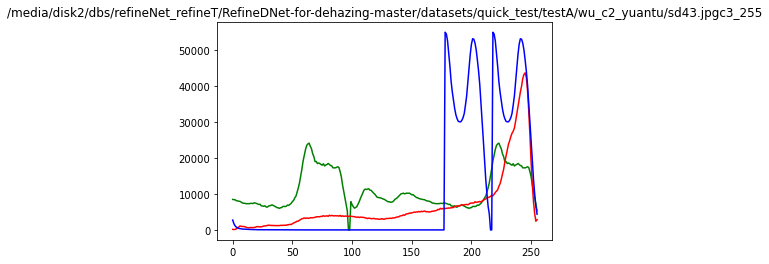

97 216
base_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu
new_dir
/media/disk2/dbs/refineNet_refineT/RefineDNet-for-dehazing-master/datasets/quick_test/testA/wu_c2_yuantu/output3_255
mov_num_b
216
mov_num_g
97


In [6]:
# 1 执行之前所有子程序后，修改为输入图片所在的路径
#im_path='./TestData_20210817/sand_dust_82/*.jpg'
#im_path='/media/disk2/dbs/dbs0329/military_pic/input_png/*.png'
# 2 执行操作
new_imgc3_255_ours(im_path)